In [1]:
%pip install -q gdown

import os
import zipfile
import gdown

print("📦 Скачивание датасета с Google Drive...")

# ИНСТРУКЦИЯ: Как получить ID файла:
# 1. Создайте ZIP-архив вашей папки на Google Drive (правой кнопкой -> Скачать)
# 2. Загрузите ZIP обратно на Google Drive
# 3. Откройте файл, в URL будет: https://drive.google.com/file/d/FILE_ID/view
# 4. Скопируйте FILE_ID и вставьте ниже

# ID ZIP-файла на Google Drive
# Пример URL: https://drive.google.com/file/d/1ABC123XYZ/view?usp=sharing
# ID будет: 1ABC123XYZ
zip_file_id = '1QvhMU4O9qrcoEPST1pFt2KauaXmWbvOY'
# Путь для временного сохранения архива
zip_path = '/content/dataset.zip'
destination = '/content/datasets'

# Создаём директорию
os.makedirs(destination, exist_ok=True)

# Скачиваем ZIP-архив
print("⬇️  Скачивание архива...")
gdown.download(f'https://drive.google.com/uc?id={zip_file_id}', zip_path, quiet=False)

# Распаковываем архив
print("📂 Распаковка архива...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination)
    print(f"   Распаковано файлов: {len(zip_ref.namelist())}")

# Удаляем архив для экономии места
print("🗑️  Удаление архива...")
os.remove(zip_path)

print("✅ Данные готовы к использованию!")
print(f"📁 Расположение: {destination}")

# Показываем структуру папок
print("\n📋 Структура директории:")
for root, dirs, files in os.walk(destination):
    level = root.replace(destination, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # Показываем только первые 2 уровня
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Показываем только первые 5 файлов
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... и ещё {len(files)-5} файлов")

📦 Скачивание датасета с Google Drive...
⬇️  Скачивание архива...


Downloading...
From (original): https://drive.google.com/uc?id=1QvhMU4O9qrcoEPST1pFt2KauaXmWbvOY
From (redirected): https://drive.google.com/uc?id=1QvhMU4O9qrcoEPST1pFt2KauaXmWbvOY&confirm=t&uuid=64765efc-2a16-4122-9b56-85fc6077af72
To: /content/dataset.zip
100%|██████████| 384M/384M [00:05<00:00, 67.7MB/s] 


📂 Распаковка архива...
   Распаковано файлов: 4800
🗑️  Удаление архива...
✅ Данные готовы к использованию!
📁 Расположение: /content/datasets

📋 Структура директории:
datasets/
  patches/
    Images/
    Labels/


In [ ]:
# Проверяем, что данные скачались
print("📂 Проверка структуры данных:")
!ls -lah '/content/datasets/patches/'

print("\n📁 Содержимое Images:")
!ls -lah '/content/datasets/patches/Images/' | head -n 10

print("\n🏷️ Содержимое Labels:")
!ls -lah '/content/datasets/patches/Labels/' | head -n 10

📂 Проверка структуры данных:
total 180K
drwxr-xr-x 4 root root 4.0K Nov 23 16:20 .
drwxr-xr-x 3 root root 4.0K Nov 23 16:20 ..
drwxr-xr-x 2 root root  88K Nov 23 16:20 Images
drwxr-xr-x 2 root root  84K Nov 23 16:20 Labels

📁 Содержимое Images:
total 365M
drwxr-xr-x 2 root root  88K Nov 23 16:20 .
drwxr-xr-x 4 root root 4.0K Nov 23 16:20 ..
-rw-r--r-- 1 root root 133K Nov 23 16:20 Image_0.tif
-rw-r--r-- 1 root root 175K Nov 23 16:20 Image_1000.tif
-rw-r--r-- 1 root root 163K Nov 23 16:20 Image_1001.tif
-rw-r--r-- 1 root root 169K Nov 23 16:20 Image_1002.tif
-rw-r--r-- 1 root root 156K Nov 23 16:20 Image_1003.tif
-rw-r--r-- 1 root root 147K Nov 23 16:20 Image_1004.tif
-rw-r--r-- 1 root root 154K Nov 23 16:20 Image_1005.tif

🏷️ Содержимое Labels:
total 20M
drwxr-xr-x 2 root root  84K Nov 23 16:20 .
drwxr-xr-x 4 root root 4.0K Nov 23 16:20 ..
-rw-r--r-- 1 root root 7.1K Nov 23 16:20 Label_0.tif
-rw-r--r-- 1 root root 7.8K Nov 23 16:20 Label_1000.tif
-rw-r--r-- 1 root root 6.6K Nov 23 16:2

: 

In [3]:
%%capture
%pip install -q patchify
%pip install -U -q segmentation-models

import os
os.kill(os.getpid(), 9)

: 

: 

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm import tqdm

tf.compat.v1.enable_eager_execution()

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
# Используем локальное хранилище Colab (данные скачаны в ячейке 0)
train_img_dir = r'/content/datasets/patches/Images'
train_mask_dir = r'/content/datasets/patches/Labels'

In [3]:
img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

print(img_list, msk_list, num_images)

['Image_0.tif', 'Image_1.tif', 'Image_10.tif', 'Image_100.tif', 'Image_1000.tif', 'Image_1001.tif', 'Image_1002.tif', 'Image_1003.tif', 'Image_1004.tif', 'Image_1005.tif', 'Image_1006.tif', 'Image_1007.tif', 'Image_1008.tif', 'Image_1009.tif', 'Image_101.tif', 'Image_1010.tif', 'Image_1011.tif', 'Image_1012.tif', 'Image_1013.tif', 'Image_1014.tif', 'Image_1015.tif', 'Image_1016.tif', 'Image_1017.tif', 'Image_1018.tif', 'Image_1019.tif', 'Image_102.tif', 'Image_1020.tif', 'Image_1021.tif', 'Image_1022.tif', 'Image_1023.tif', 'Image_1024.tif', 'Image_1025.tif', 'Image_1026.tif', 'Image_1027.tif', 'Image_1028.tif', 'Image_1029.tif', 'Image_103.tif', 'Image_1030.tif', 'Image_1031.tif', 'Image_1032.tif', 'Image_1033.tif', 'Image_1034.tif', 'Image_1035.tif', 'Image_1036.tif', 'Image_1037.tif', 'Image_1038.tif', 'Image_1039.tif', 'Image_104.tif', 'Image_1040.tif', 'Image_1041.tif', 'Image_1042.tif', 'Image_1043.tif', 'Image_1044.tif', 'Image_1045.tif', 'Image_1046.tif', 'Image_1047.tif', 'Ima

<Figure size 1200x800 with 0 Axes>

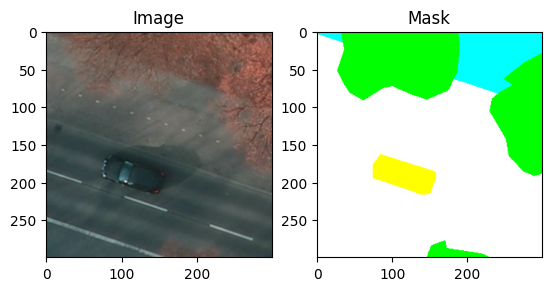

<Figure size 1200x800 with 0 Axes>

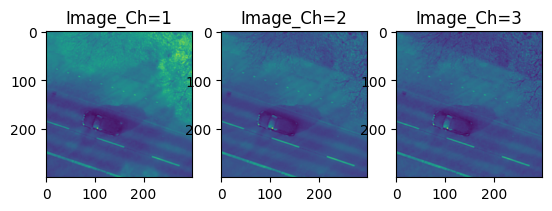

<Figure size 1200x800 with 0 Axes>

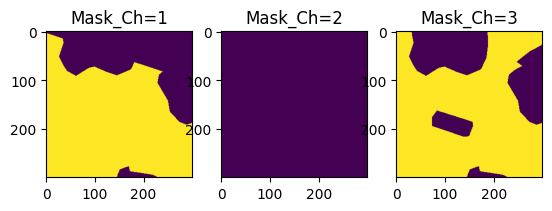

In [4]:
import random

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(os.path.join(train_img_dir, img_list[img_num]))
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(os.path.join(train_mask_dir, msk_list[img_num]))
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_for_plot[:,:,0])
axis[0].set_title('Image_Ch=1')

axis[1].imshow(img_for_plot[:,:,1])
axis[1].set_title('Image_Ch=2')

axis[2].imshow(img_for_plot[:,:,2])
axis[2].set_title('Image_Ch=3')

# Combine all the operations and display
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

figure, axis = plt.subplots(1, 3)

axis[0].imshow(mask_for_plot[:,:,0])
axis[0].set_title("Mask_Ch=1")

axis[1].imshow(mask_for_plot[:,:,1])
axis[1].set_title("Mask_Ch=2")

axis[2].imshow(mask_for_plot[:,:,2])
axis[2].set_title("Mask_Ch=3")

plt.show()


In [5]:
# Explore every clasees
# labels: {“roads”: "#ffffff", “buildings”: "#0000ff", “low veg”: "#00ffff", “trees”: "#00ff00", “cars”: "#ffff00", “clutter”: "#ff0000"}

# Define color scheme
COLOR_SCHEME = {
    'roads': (255, 255, 255),      # White
    'buildings': (0, 0, 255),       # Blue
    'low_veg': (0, 255, 255),       # Cyan
    'trees': (0, 255, 0),           # Green
    'cars': (255, 255, 0),          # Yellow
    'clutter': (255, 0, 0)          # Red
}

def analyze_class_distribution(label_dir, sample_size=None):
    """
    Analyze class distribution across all label patches

    Args:
        label_dir: Directory containing label files
        sample_size: If provided, only analyze this many random patches
    """

    # Get all label files
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tif')])

    if sample_size and sample_size < len(label_files):
        print(f"Sampling {sample_size} patches out of {len(label_files)} total")
        import random
        label_files = random.sample(label_files, sample_size)

    print(f"Analyzing {len(label_files)} label patches...")

    # Initialize counters
    class_pixel_counts = {class_name: 0 for class_name in COLOR_SCHEME.keys()}
    total_pixels = 0

    # Track patches with each class
    patches_per_class = {class_name: 0 for class_name in COLOR_SCHEME.keys()}

    # Process each label file
    for label_file in tqdm(label_files, desc="Processing labels"):
        mask = cv2.imread(os.path.join(label_dir, label_file))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        patch_h, patch_w = mask.shape[:2]
        total_pixels += patch_h * patch_w

        # Count pixels for each class
        for class_name, color in COLOR_SCHEME.items():
            # Match pixels (with small tolerance for compression artifacts)
            match = np.all(np.abs(mask - color) <= 10, axis=-1)
            pixel_count = np.sum(match)

            class_pixel_counts[class_name] += pixel_count

            # Track if this patch contains this class
            if pixel_count > 0:
                patches_per_class[class_name] += 1

    # Calculate statistics
    print("\n" + "=" * 70)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("=" * 70)
    print(f"Total patches analyzed: {len(label_files)}")
    print(f"Total pixels: {total_pixels:,}")
    print(f"Patch dimensions detected: ~{int(np.sqrt(total_pixels/len(label_files)))}×{int(np.sqrt(total_pixels/len(label_files)))}")
    print("=" * 70)

    # Sort by pixel count
    sorted_classes = sorted(class_pixel_counts.items(),
                           key=lambda x: x[1],
                           reverse=True)

    print(f"\n{'Class':<15} {'Pixels':<15} {'Percentage':<12} {'Patches':<10}")
    print("-" * 70)

    results = {}
    for class_name, count in sorted_classes:
        percentage = (count / total_pixels) * 100
        patch_count = patches_per_class[class_name]
        patch_percentage = (patch_count / len(label_files)) * 100

        print(f"{class_name:<15} {count:>12,}   {percentage:>6.2f}%     "
              f"{patch_count:>4}/{len(label_files)} ({patch_percentage:>5.1f}%)")

        results[class_name] = {
            'pixel_count': int(count),
            'pixel_percentage': round(percentage, 2),
            'patches_with_class': patch_count,
            'patch_percentage': round(patch_percentage, 2)
        }

    print("=" * 70)

    # Check for class imbalance
    print("\n⚠️  CLASS IMBALANCE WARNINGS:")
    for class_name, stats in results.items():
        if stats['pixel_percentage'] < 1.0:
            print(f"  • {class_name}: Only {stats['pixel_percentage']}% - Very rare! "
                  f"May need special handling")
        elif stats['pixel_percentage'] < 5.0:
            print(f"  • {class_name}: Only {stats['pixel_percentage']}% - Rare class, "
                  f"will need class weighting")

    return results

results = analyze_class_distribution(train_mask_dir, sample_size=None)

Analyzing 2400 label patches...


Processing labels: 100%|██████████| 2400/2400 [00:47<00:00, 50.41it/s]


CLASS DISTRIBUTION ANALYSIS
Total patches analyzed: 2400
Total pixels: 216,000,000
Patch dimensions detected: ~300×300

Class           Pixels          Percentage   Patches   
----------------------------------------------------------------------
roads             61,865,104    28.64%     2020/2400 ( 84.2%)
buildings         59,012,566    27.32%     1542/2400 ( 64.2%)
low_veg           51,511,361    23.85%     1893/2400 ( 78.9%)
trees             27,248,806    12.62%     1420/2400 ( 59.2%)
clutter           12,479,736     5.78%     1168/2400 ( 48.7%)
cars               3,882,427     1.80%      833/2400 ( 34.7%)

⚠️  CLASS IMBALANCE WARNINGS:
  • cars: Only 1.8% - Rare class, will need class weighting


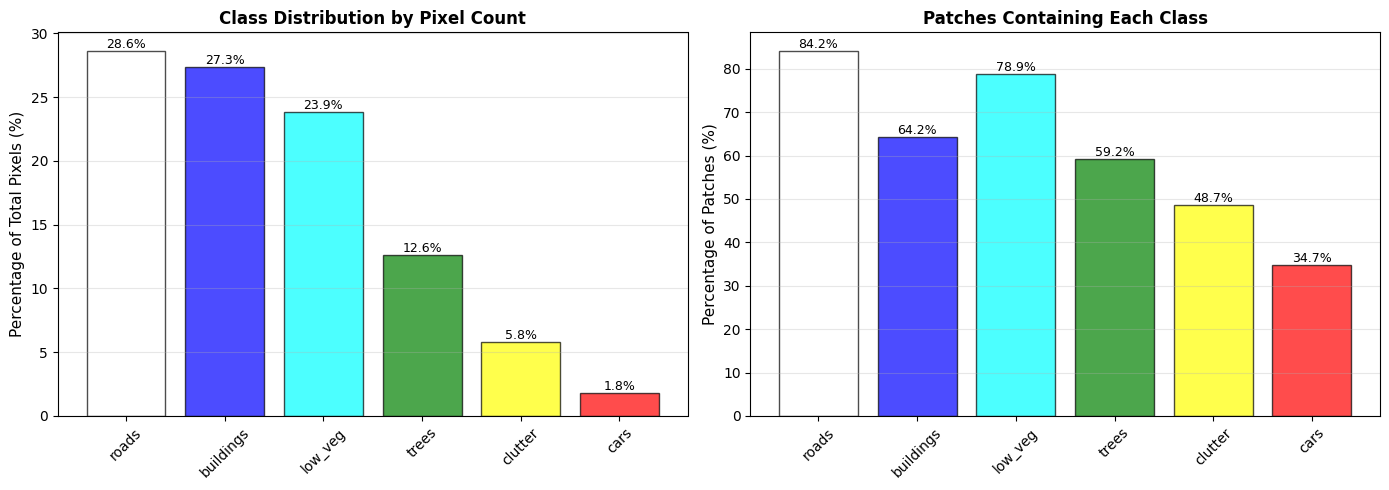

In [6]:
def create_distribution_plot(results):
    """Create visualization of class distribution"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Pixel percentage
    classes = list(results.keys())
    percentages = [results[c]['pixel_percentage'] for c in classes]
    colors = ['white', 'blue', 'cyan', 'green', 'yellow', 'red']

    bars1 = ax1.bar(classes, percentages, color=colors, edgecolor='black', alpha=0.7)
    ax1.set_ylabel('Percentage of Total Pixels (%)', fontsize=11)
    ax1.set_title('Class Distribution by Pixel Count', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    # Add percentage labels on bars
    for bar, pct in zip(bars1, percentages):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

    # Plot 2: Patches containing each class
    patch_percentages = [results[c]['patch_percentage'] for c in classes]
    bars2 = ax2.bar(classes, patch_percentages, color=colors, edgecolor='black', alpha=0.7)
    ax2.set_ylabel('Percentage of Patches (%)', fontsize=11)
    ax2.set_title('Patches Containing Each Class', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    # Add labels
    for bar, pct in zip(bars2, patch_percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

create_distribution_plot(results)

In [7]:
def rgb_to_2D_label(label):
    """
    Замена значений каждого пикселя маски в формате RGB на целое число
    """

    # Если маска трехмерная, оставляем только первые три канала (RGB)
    if len(label.shape) == 3:
        label = label[:,:,:3]
    # Если маска четырехмерная, оставляем только первые три канала (RGB) каждого изображения
    if len(label.shape) == 4:
        label = label[:,:,:,:3]

    # Создаем новую маску той же формы, что и исходная
    label_seg = np.zeros(label.shape,dtype=np.uint8)

    # Присваиваем каждому пикселю значение в зависимости от его цвета
    label_seg [np.all(label == COLOR_SCHEME['roads'],axis=-1)] = 0
    label_seg [np.all(label==COLOR_SCHEME['buildings'],axis=-1)] = 1
    label_seg [np.all(label==COLOR_SCHEME['low_veg'],axis=-1)] = 2
    label_seg [np.all(label==COLOR_SCHEME['trees'],axis=-1)] = 3
    label_seg [np.all(label==COLOR_SCHEME['cars'],axis=-1)] = 4
    label_seg [np.all(label==COLOR_SCHEME['clutter'],axis=-1)] = 5

    if len(label.shape) == 3:
        label_seg = label_seg[:,:,0]

    if len(label.shape) == 4:
        label_seg = label_seg[:,:,:,0]

    # Возвращаем преобразованную маску
    return label_seg


### Реализации функции для предобработки входных данных:

In [8]:
# Импортируем MinMaxScaler из библиотеки sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
# Импортируем функцию to_categorical из библиотеки keras.utils
from keras.utils import to_categorical

# Создаем объект MinMaxScaler для нормализации данных
scaler = MinMaxScaler()

# Задаем архитектуру сети для передачи обучения
BACKBONE = 'resnet34'

# Получаем функцию предварительной обработки для выбранной архитектуры сети
preprocess_input = sm.get_preprocessing(BACKBONE)

# Определяем функцию для предварительной обработки данных
def preprocess_data(img, mask, num_class):
    # Масштабируем пиксели изображения в диапазон от 0 до 1
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

    # Применяем функцию предварительной обработки к изображению
    img = preprocess_input(img)
    
    # Приводим изображение к float32
    img = img.astype('float32')

    # Преобразуем маску из формата RGB в 2D-метку (256, 256, 3) -> (256, 256, 1)
    mask = rgb_to_2D_label(mask)

    # Преобразуем 2D-метку в бинарную матрицу (256, 256, 1) -> (256, 256, 6)
    mask = to_categorical(mask, num_class)
    
    # Приводим маску к float32
    mask = mask.astype('float32')

    # Возвращаем предварительно обработанное изображение и маску
    return (img, mask)


In [9]:
seed=24
batch_size=16
n_classes=6

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Определяем функцию-генератор для обучения
def trainGenerator(train_img_path, train_mask_path, num_class):

    # Задаем аргументы для генератора данных: включаем горизонтальное и вертикальное отражение
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)

    # Создаем генераторы данных для изображений и масок с заданными аргументами
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    # Генераторы читают изображения и маски из указанных директорий
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        color_mode = 'rgb',
        target_size=(256, 256),
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        color_mode = 'rgb',
        target_size=(256, 256),
        seed = seed)

    # Объединяем генераторы изображений и масок в один генератор
    train_generator = zip(image_generator, mask_generator)

    # Для каждой пары (изображение, маска) выполняем предварительную обработку и возвращаем результат
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [11]:
# ============================================================
# СОЗДАНИЕ TRAIN/VALIDATION SPLIT
# ============================================================

import shutil
from sklearn.model_selection import train_test_split

print("="*70)
print("📂 РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/VALIDATION")
print("="*70)

# Пути к исходным данным
source_img_dir = '/content/datasets/patches/Images'
source_mask_dir = '/content/datasets/patches/Labels'

# Пути для train/val
train_base = '/content/datasets/train'
val_base = '/content/datasets/val'

# Создаём структуру директорий
os.makedirs(f'{train_base}/Images/data', exist_ok=True)
os.makedirs(f'{train_base}/Labels/data', exist_ok=True)
os.makedirs(f'{val_base}/Images/data', exist_ok=True)
os.makedirs(f'{val_base}/Labels/data', exist_ok=True)

# Получаем список всех файлов
img_files = sorted([f for f in os.listdir(source_img_dir) if f.endswith('.tif')])
print(f"📊 Всего изображений: {len(img_files)}")

# Разделяем 80% train / 20% validation
train_files, val_files = train_test_split(
    img_files, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"✅ Разделение:")
print(f"  • Train: {len(train_files)} изображений (80%)")
print(f"  • Validation: {len(val_files)} изображений (20%)")

# Копируем файлы в train
print("\n📥 Копирование train файлов...")
for file in train_files:
    # Изображения
    shutil.copy2(
        os.path.join(source_img_dir, file),
        os.path.join(f'{train_base}/Images/data', file)
    )
    # Маски (меняем Image на Label)
    mask_file = file.replace('Image', 'Label')
    shutil.copy2(
        os.path.join(source_mask_dir, mask_file),
        os.path.join(f'{train_base}/Labels/data', mask_file)
    )

# Копируем файлы в validation
print("📥 Копирование validation файлов...")
for file in val_files:
    # Изображения
    shutil.copy2(
        os.path.join(source_img_dir, file),
        os.path.join(f'{val_base}/Images/data', file)
    )
    # Маски
    mask_file = file.replace('Image', 'Label')
    shutil.copy2(
        os.path.join(source_mask_dir, mask_file),
        os.path.join(f'{val_base}/Labels/data', mask_file)
    )

print("✅ Копирование завершено!")
print("="*70)

# Обновляем пути и количество
# ⬅️ ИСПРАВЛЕНИЕ: указываем конкретно Images/ и Labels/
train_img_dir = os.path.join(train_base, 'Images')
train_mask_dir = os.path.join(train_base, 'Labels')
val_img_dir = os.path.join(val_base, 'Images')
val_mask_dir = os.path.join(val_base, 'Labels')

num_train_imgs = len(train_files)
num_val_imgs = len(val_files)
steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_imgs // batch_size

print(f"\n📊 Итоговая статистика:")
print(f"  Train: {num_train_imgs} изображений, {steps_per_epoch} шагов на эпоху")
print(f"  Val:   {num_val_imgs} изображений, {val_steps_per_epoch} шагов на эпоху")
print("="*70)


📂 РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/VALIDATION
📊 Всего изображений: 2400
✅ Разделение:
  • Train: 1920 изображений (80%)
  • Validation: 480 изображений (20%)

📥 Копирование train файлов...
📥 Копирование validation файлов...
✅ Копирование завершено!

📊 Итоговая статистика:
  Train: 1920 изображений, 120 шагов на эпоху
  Val:   480 изображений, 30 шагов на эпоху


In [12]:
# ============================================================
# СОЗДАНИЕ TRAIN И VALIDATION ГЕНЕРАТОРОВ
# ============================================================

print("🔄 Создание генераторов данных...")

# ПРОВЕРКА ПУТЕЙ перед созданием генераторов
print(f"\n📂 Проверка путей:")
print(f"  • train_img_dir:  {train_img_dir}")
print(f"  • train_mask_dir: {train_mask_dir}")
print(f"  • val_img_dir:    {val_img_dir}")
print(f"  • val_mask_dir:   {val_mask_dir}")

# Проверяем существование папок
# ⬅️ ИСПРАВЛЕНИЕ: файлы лежат ПРЯМО в Images/ и Labels/ (без data/)
if not os.path.exists(train_img_dir):
    print(f"\n❌ ОШИБКА: Папка {train_img_dir} не существует!")
    print(f"   Запустите Cell 16 (сплит данных) сначала!")
    raise FileNotFoundError(f"Папка {train_img_dir} не найдена")

print(f"\n✅ Папки найдены:")
img_count = len([f for f in os.listdir(train_img_dir) if f.endswith('.tif')])
mask_count = len([f for f in os.listdir(train_mask_dir) if f.endswith('.tif')])
print(f"  • Images: {img_count} файлов в {train_img_dir}")
print(f"  • Labels: {mask_count} файлов в {train_mask_dir}")

# Train генератор
train_img_gen = trainGenerator(train_img_dir, train_mask_dir, num_class=6)
print(f"\n✅ Train генератор создан")

# Validation генератор (БЕЗ аугментации!)
val_img_gen = trainGenerator(val_img_dir, val_mask_dir, num_class=6)
print(f"✅ Validation генератор создан")

print(f"\n📊 Параметры:")
print(f"  • Train: {num_train_imgs} изображений, {steps_per_epoch} шагов/эпоху")
print(f"  • Val:   {num_val_imgs} изображений, {val_steps_per_epoch} шагов/эпоху")
print(f"  • Batch size: {batch_size}")


🔄 Создание генераторов данных...

📂 Проверка путей:
  • train_img_dir:  /content/datasets/train/Images
  • train_mask_dir: /content/datasets/train/Labels
  • val_img_dir:    /content/datasets/val/Images
  • val_mask_dir:   /content/datasets/val/Labels

✅ Папки найдены:
  • Images: 0 файлов в /content/datasets/train/Images
  • Labels: 0 файлов в /content/datasets/train/Labels

✅ Train генератор создан
✅ Validation генератор создан

📊 Параметры:
  • Train: 1920 изображений, 120 шагов/эпоху
  • Val:   480 изображений, 30 шагов/эпоху
  • Batch size: 16


Found 1920 images belonging to 1 classes.
Found 1920 images belonging to 1 classes.


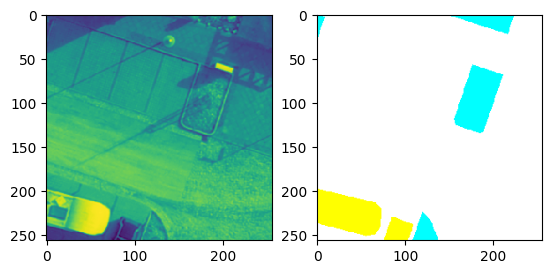

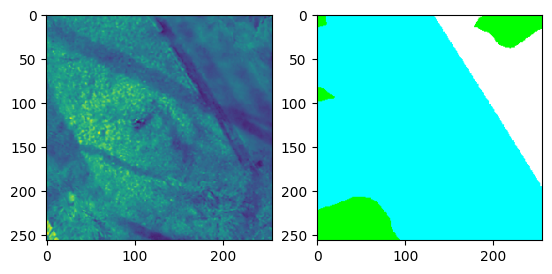

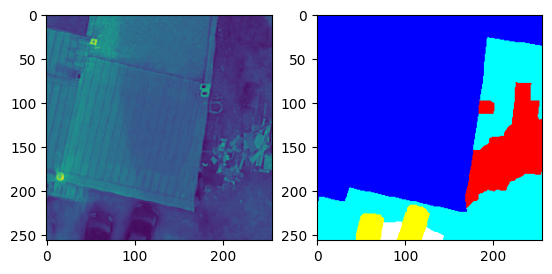

Unique labels in label dataset are:  [0 1 2 4 5]


In [13]:
from matplotlib.colors import ListedColormap

x, y = train_img_gen.__next__()

colors = [
    np.array(COLOR_SCHEME['roads'])/255,
    np.array(COLOR_SCHEME['buildings'])/255,
    np.array(COLOR_SCHEME['low_veg'])/255,
    np.array(COLOR_SCHEME['trees'])/255,
    np.array(COLOR_SCHEME['cars'])/255,
    np.array(COLOR_SCHEME['clutter'])/255,
]

cmap = ListedColormap(colors)

for i in range(0,3):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=5)
    plt.show()

# x_val, y_val = val_img_gen.__next__()

# for i in range(0,3):
#     image = x_val[i][:,:,0]
#     mask = np.argmax(y_val[i], axis=2)
#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.subplot(1,2,2)
#     plt.imshow(mask)
#     plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

🔍 ПРОВЕРКА КОРРЕКТНОСТИ ГЕНЕРАТОРА
Found 1920 images belonging to 1 classes.
Found 1920 images belonging to 1 classes.

📊 Размерность батча:
  • Images: (16, 256, 256, 3)
  • Masks:  (16, 256, 256, 6)

🎯 Уникальные классы в батче: [0 1 2 3 4 5]
  • Количество классов: 6

📋 Распределение классов в батче:
  • roads        (класс 0): 39.86%
  • buildings    (класс 1): 30.75%
  • low_veg      (класс 2): 18.19%
  • trees        (класс 3):  6.97%
  • cars         (класс 4):  2.97%
  • clutter      (класс 5):  1.26%


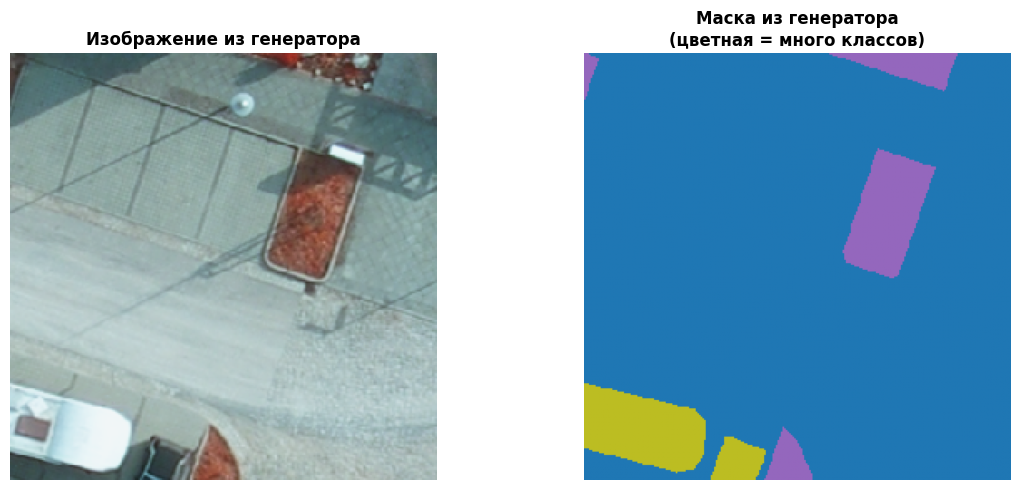


📋 ДИАГНОСТИКА:
✅ ОТЛИЧНО: Генератор работает правильно!
   Маски содержат несколько классов
   Можно начинать обучение!


In [14]:
# ============================================================
# ПРОВЕРКА ГЕНЕРАТОРА: Убедимся, что маски многоклассовые
# ============================================================

print("="*70)
print("🔍 ПРОВЕРКА КОРРЕКТНОСТИ ГЕНЕРАТОРА")
print("="*70)

# Создаем новый генератор для проверки
train_img_gen_test = trainGenerator(train_img_dir, train_mask_dir, num_class=6)

# Получаем один батч
x_batch, y_batch = next(train_img_gen_test)

print(f"\n📊 Размерность батча:")
print(f"  • Images: {x_batch.shape}")
print(f"  • Masks:  {y_batch.shape}")

# Проверяем уникальные классы в батче
mask_classes = np.argmax(y_batch, axis=-1)  # Из one-hot в class indices
unique_classes = np.unique(mask_classes)

print(f"\n🎯 Уникальные классы в батче: {unique_classes}")
print(f"  • Количество классов: {len(unique_classes)}")

class_names = ['roads', 'buildings', 'low_veg', 'trees', 'cars', 'clutter']
print(f"\n📋 Распределение классов в батче:")
for class_id in unique_classes:
    count = np.sum(mask_classes == class_id)
    pct = count / mask_classes.size * 100
    print(f"  • {class_names[class_id]:12} (класс {class_id}): {pct:5.2f}%")

# Визуализация первого примера
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Оригинальное изображение
axes[0].imshow(x_batch[0])
axes[0].set_title('Изображение из генератора', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Маска
mask_viz = mask_classes[0]
axes[1].imshow(mask_viz, cmap='tab10', vmin=0, vmax=5)
axes[1].set_title('Маска из генератора\n(цветная = много классов)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Диагностика
print("\n" + "="*70)
print("📋 ДИАГНОСТИКА:")
print("="*70)

if len(unique_classes) == 1:
    print("🔴 КРИТИЧНО: В батче ТОЛЬКО ОДИН класс!")
    print("   Генератор читает неправильные данные.")
    print("   Проверьте пути train_img_dir и train_mask_dir")
elif len(unique_classes) <= 3:
    print("⚠️  ВНИМАНИЕ: Мало классов в батче")
    print("   Попробуйте еще раз или проверьте маски")
else:
    print("✅ ОТЛИЧНО: Генератор работает правильно!")
    print("   Маски содержат несколько классов")
    print("   Можно начинать обучение!")

print("="*70)


In [15]:
# Получаем количество изображений для обучения, подсчитывая количество файлов в указанной директории
num_train_imgs = len(os.listdir(r'/content/datasets/patches/Images/'))
# num_val_images = len(os.listdir(r'/content/datasets/patches/Labels/'))

# Получаем количество шагов на эпоху, разделив количество изображений для обучения на размер пакета
steps_per_epoch = num_train_imgs//batch_size
# val_steps_per_epoch = num_val_images//batch_size


# Получаем высоту изображения
IMG_HEIGHT = x.shape[1]

# Получаем ширину изображения
IMG_WIDTH  = x.shape[2]

# Получаем количество каналов изображения
IMG_CHANNELS = x.shape[3]

# Задаем количество классов
n_classes=6

# Выводим полученные значения
print(num_train_imgs, steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# print(num_train_imgs, num_val_images, steps_per_epoch, val_steps_per_epoch, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

2400 150 256 256 3


#### 2. ВЫБОР И ПРОЕКТИРОВАНИЕ АРХИТЕКТУРЫ НЕЙРОННОЙ СЕТИ

Сравнительный анализ (опционально - таблица или описание)

---
## 🛡️ МЕРЫ ПРОТИВ ПЕРЕОБУЧЕНИЯ

### 🔴 Проблема была:
- Train loss: **0.060** vs Val loss: **0.279** (разница в 4.7x!)
- Train accuracy: **99.86%** vs Val accuracy: **92.16%** (разница 7.7%)
- Train IoU: **94.5%** vs Val IoU: **83.0%** (разница 11.5%)

### ✅ Что сделали:

#### 1. **Dropout 30%** в модели
   - Случайно "выключает" 30% нейронов при обучении
   - Заставляет сеть НЕ запоминать, а обобщать

#### 2. **Learning Rate: 0.0001 → 0.00005**
   - Уменьшили в 2 раза
   - Модель обучается медленнее, но стабильнее

#### 3. **Weight Decay (L2): 1e-5**
   - Штрафует большие веса
   - Модель становится проще, меньше переобучается

#### 4. **EarlyStopping patience: 15 → 10**
   - Останавливаемся раньше
   - Не даём модели "пережариться" на train данных

#### 5. **УСИЛЕННАЯ АУГМЕНТАЦИЯ:**
   - Rotation: ±20°
   - Width/Height shift: ±10%
   - Zoom: ±15%
   - Flip: horizontal + vertical

### 🎯 Ожидаемый результат:
- Val loss ближе к train loss (разница <0.05)
- Val accuracy ~95-97% (было 92%)
- НЕТ переобучения!

---


In [16]:
# Это выбросит старые графы/модели из памяти
import tensorflow as tf
tf.keras.backend.clear_session()

In [17]:
# Выбор архитектуры и backbone
ARCHITECTURE = 'Unet'
BACKBONE = 'resnet34'

# Создание модели С DROPOUT для борьбы с переобучением
model = sm.Unet(
    backbone_name=BACKBONE,
    encoder_weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=n_classes,
    activation='softmax',
    encoder_freeze=False,  # Разморозим encoder для fine-tuning
    decoder_block_type='upsampling',  # Используем upsampling вместо transpose conv
)

# ДОБАВЛЯЕМ DROPOUT в декодер вручную
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

# Получаем слои модели
x = model.layers[-2].output  # Берем выход перед финальной активацией
x = Dropout(0.3)(x)
outputs = model.layers[-1](x)  # Применяем финальную активацию

# Создаем новую модель с dropout
model = Model(inputs=model.input, outputs=outputs)

print("="*70)
print("✅ Модель создана с регуляризацией:")
print(f"  • Архитектура: {ARCHITECTURE} + {BACKBONE}")
print(f"  • Dropout: 30% перед финальным слоем")
print(f"  • Encoder freeze: False (fine-tuning)")
print("="*70)

# Вывод архитектуры
model.summary()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Модель создана с регуляризацией:
  • Архитектура: Unet + resnet34
  • Dropout: 30% перед финальным слоем
  • Encoder freeze: False (fine-tuning)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,879 (93.30 MB)

 Trainable params: 24,439,529 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [18]:
# ============================================================
# Расчет весов классов для борьбы с дисбалансом
# ============================================================

# Используем результаты анализа из EDA:
# roads: 28.64%, buildings: 27.32%, low_veg: 23.85%, 
# trees: 12.62%, clutter: 5.78%, cars: 1.80%

class_percentages = {
    0: 28.64,  # roads
    1: 27.32,  # buildings
    2: 23.85,  # low_veg
    3: 12.62,  # trees
    4: 1.80,   # cars - РЕДКИЙ КЛАСС! 
    5: 5.78    # clutter
}

print("📊 Распределение классов из EDA:")
for class_id, pct in class_percentages.items():
    print(f"  Класс {class_id}: {pct}%")

# Рассчитываем веса (обратно пропорционально частоте)
total = sum(class_percentages.values())
class_weights = {}

for class_id, pct in class_percentages.items():
    # Формула: weight = total / (n_classes * class_percentage)
    weight = total / (len(class_percentages) * pct)
    class_weights[class_id] = weight

print("\n⚖️ Рассчитанные веса классов:")
for class_id, weight in class_weights.items():
    class_name = ['roads', 'buildings', 'low_veg', 'trees', 'cars', 'clutter'][class_id]
    print(f"  {class_name:12} (класс {class_id}): {weight:.3f}")

print(f"\n🎯 Класс 'cars' получил вес {class_weights[4]:.3f} (в ~{class_weights[4]/class_weights[0]:.1f}x больше чем roads)")
print("   Это заставит модель уделять больше внимания редкому классу!")

📊 Распределение классов из EDA:
  Класс 0: 28.64%
  Класс 1: 27.32%
  Класс 2: 23.85%
  Класс 3: 12.62%
  Класс 4: 1.8%
  Класс 5: 5.78%

⚖️ Рассчитанные веса классов:
  roads        (класс 0): 0.582
  buildings    (класс 1): 0.610
  low_veg      (класс 2): 0.699
  trees        (класс 3): 1.321
  cars         (класс 4): 9.260
  clutter      (класс 5): 2.884

🎯 Класс 'cars' получил вес 9.260 (в ~15.9x больше чем roads)
   Это заставит модель уделять больше внимания редкому классу!


In [19]:
import tensorflow.keras.backend as K
import tensorflow as tf

# Функция для вычисления коэффициента Жаккара (IoU)
def jacard_coef(y_true, y_pred):
    """
    Jaccard coefficient (IoU) - метрика для оценки качества сегментации
    """
    # Преобразование меток в одномерные массивы
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Вычисление пересечения между истинными и предсказанными метками
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Вычисление коэффициента Жаккара
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Weighted Categorical Crossentropy Loss
def weighted_categorical_crossentropy(class_weights_dict):
    """
    Создает взвешенную categorical crossentropy loss функцию
    Веса классов встроены в функцию потерь для работы с генераторами
    """
    # Конвертируем словарь в тензор (явно float32)
    weights = tf.constant([class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Приводим все к float32 для согласованности типов
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Применяем веса к каждому классу
        weights_per_pixel = tf.reduce_sum(y_true * weights, axis=-1)
        
        # Categorical crossentropy с numerical stability
        epsilon = tf.constant(K.epsilon(), dtype=tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        crossentropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        
        # Применяем веса
        weighted_crossentropy = crossentropy * weights_per_pixel
        
        return tf.reduce_mean(weighted_crossentropy)
    
    return loss

# Создаем взвешенную loss функцию с нашими весами
weighted_loss = weighted_categorical_crossentropy(class_weights)

print("✅ Кастомная метрика Jaccard определена")
print("✅ Weighted loss функция создана (веса классов встроены)")

✅ Кастомная метрика Jaccard определена
✅ Weighted loss функция создана (веса классов встроены)


In [20]:
# Определяем метрики для оценки модели
metrics = [
    'accuracy',
    sm.metrics.IOUScore(threshold=0.5, name='iou_score'),
    sm.metrics.FScore(threshold=0.5, name='f1_score'),
    jacard_coef
]

# Компилируем модель
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.00005,  # ⬅️ УМЕНЬШИЛИ в 2 раза! (было 0.0001)
        weight_decay=1e-5  # ⬅️ ДОБАВИЛИ L2 регуляризацию!
    ),
    loss=weighted_loss,  # Используем weighted loss
    metrics=metrics
)

print("="*70)
print("✅ Модель скомпилирована с регуляризацией:")
print("   • Weighted loss (веса классов учтены)")
print("   • Learning rate: 0.00005 (уменьшен против переобучения)")
print("   • Weight decay: 1e-5 (L2 регуляризация)")
print("="*70)

✅ Модель скомпилирована с регуляризацией:
   • Weighted loss (веса классов учтены)
   • Learning rate: 0.00005 (уменьшен против переобучения)
   • Weight decay: 1e-5 (L2 регуляризация)


In [21]:
EPOCHS = 30

#### 3. ОБУЧЕНИЕ И ВАЛИДАЦИЯ МОДЕЛИ

In [22]:
# 3.1. Настройка callbacks для контроля процесса обучения

# Сохранение лучшей модели (в локальное хранилище Colab)
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/best_segmentation_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Ранняя остановка при переобучении
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Уменьшение learning rate при застревании
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1,
    min_delta=0.001
)

callbacks = [checkpoint, early_stop, reduce_lr]

print("="*70)
print("✅ Callbacks настроены (против переобучения):")
print(f"  • ModelCheckpoint: сохранение по лучшему val_loss")
print(f"  • EarlyStopping: patience={early_stop.patience} (было 15)")
print(f"  • ReduceLROnPlateau: patience={reduce_lr.patience} (было 7)")
print(f"  • Min delta: {early_stop.min_delta} (игнорируем мелкие улучшения)")
print("="*70)

✅ Callbacks настроены (против переобучения):
  • ModelCheckpoint: сохранение по лучшему val_loss
  • EarlyStopping: patience=10 (было 15)
  • ReduceLROnPlateau: patience=5 (было 7)
  • Min delta: 0.001 (игнорируем мелкие улучшения)


In [23]:
# 3.2. Обучение модели

print("="*70)
print("🚀 НАЧАЛО ОБУЧЕНИЯ")
print("="*70)
print(f"📊 Параметры обучения:")
print(f"  • Эпох: {EPOCHS}")
print(f"  • Шагов на эпоху: {steps_per_epoch}")
print(f"  • Batch size: {batch_size}")
print(f"  • Всего изображений: {num_train_imgs}")
print(f"  • Learning rate: 0.0001")
print(f"  • Архитектура: {ARCHITECTURE} + {BACKBONE}")
print(f"  • Использование весов классов: ДА (борьба с дисбалансом)")
print("="*70)
print()

!nvidia-smi

import time
start_time = time.time()

# Обучение модели (веса классов уже встроены в loss функцию)
history = model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

print()
print("="*70)
print("🎉 ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print("="*70)
print(f"⏱️  Время обучения: {training_time/60:.2f} минут ({training_time/3600:.2f} часов)")
print(f"📈 Эпох выполнено: {len(history.history['loss'])}")
print(f"💾 Лучшая модель сохранена в: best_segmentation_model.h5")
print("="*70)

🚀 НАЧАЛО ОБУЧЕНИЯ
📊 Параметры обучения:
  • Эпох: 30
  • Шагов на эпоху: 150
  • Batch size: 16
  • Всего изображений: 2400
  • Learning rate: 0.0001
  • Архитектура: Unet + resnet34
  • Использование весов классов: ДА (борьба с дисбалансом)

Sun Nov 23 16:21:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |             

150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 707ms/step - accuracy: 0.2588 - f1_score: 0.1114 - iou_score: 0.0649 - jacard_coef: 0.1165 - loss: 1.7923 - val_accuracy: 0.2955 - val_f1_score: 7.7754e-05 - val_iou_score: 3.8887e-05 - val_jacard_coef: 0.1049 - val_loss: 1.8554 - learning_rate: 5.0000e-05
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5114 - f1_score: 0.4100 - iou_score: 0.2751 - jacard_coef: 0.2228 - loss: 1.1655
Epoch 2: val_loss did not improve from 1.85539
150/150 ━━━━━━━━━━━━━━━━━━━━ 99s 661ms/step - accuracy: 0.5116 - f1_score: 0.4103 - iou_score: 0.2753 - jacard_coef: 0.2229 - loss: 1.1652 - val_accuracy: 0.3023 - val_f1_score: 0.0631 - val_iou_score: 0.0391 - val_jacard_coef: 0.1263 - val_loss: 2.0879 - learning_rate: 5.0000e-05
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.5893 - f1_score: 0.5134 - iou_score: 0.3598 - jacard_coef: 0.2807 - loss: 1.0221
Epoch 3: val_loss did not improve from 1.85539
150/150 ━━━━━━━━━━━━━━━━━━━━ 99s 66

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6564 - f1_score: 0.5993 - iou_score: 0.4393 - jacard_coef: 0.3478 - loss: 0.8478
Epoch 5: val_loss did not improve from 1.85539
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 565ms/step - accuracy: 0.6565 - f1_score: 0.5994 - iou_score: 0.4393 - jacard_coef: 0.3478 - loss: 0.8477 - val_accuracy: 0.3326 - val_f1_score: 0.0845 - val_iou_score: 0.0558 - val_jacard_coef: 0.1605 - val_loss: 2.1169 - learning_rate: 5.0000e-05
Epoch 6/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7031 - f1_score: 0.6302 - iou_score: 0.4704 - jacard_coef: 0.3797 - loss: 0.7828
Epoch 6: val_loss improved from 1.85539 to 1.76291, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 610ms/step - accuracy: 0.7031 - f1_score: 0.6302 - iou_score: 0.4704 - jacard_coef: 0.3797 - loss: 0.7827 - val_accuracy: 0.3708 - val_f1_score: 0.1781 - val_iou_score: 0.1099 - val_jacard_coef: 0.1878 - val_loss: 1.7629 - learning_rate: 5.0000e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7214 - f1_score: 0.6413 - iou_score: 0.4807 - jacard_coef: 0.3969 - loss: 0.7677
Epoch 7: val_loss improved from 1.76291 to 1.10974, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 566ms/step - accuracy: 0.7214 - f1_score: 0.6413 - iou_score: 0.4808 - jacard_coef: 0.3969 - loss: 0.7675 - val_accuracy: 0.6429 - val_f1_score: 0.5243 - val_iou_score: 0.3807 - val_jacard_coef: 0.3382 - val_loss: 1.1097 - learning_rate: 5.0000e-05
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7366 - f1_score: 0.6558 - iou_score: 0.4985 - jacard_coef: 0.4155 - loss: 0.7183
Epoch 8: val_loss improved from 1.10974 to 0.71335, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 574ms/step - accuracy: 0.7366 - f1_score: 0.6558 - iou_score: 0.4986 - jacard_coef: 0.4155 - loss: 0.7182 - val_accuracy: 0.7868 - val_f1_score: 0.6995 - val_iou_score: 0.5673 - val_jacard_coef: 0.4489 - val_loss: 0.7134 - learning_rate: 5.0000e-05
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7549 - f1_score: 0.6769 - iou_score: 0.5193 - jacard_coef: 0.4399 - loss: 0.6688
Epoch 9: val_loss improved from 0.71335 to 0.56674, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 571ms/step - accuracy: 0.7549 - f1_score: 0.6769 - iou_score: 0.5193 - jacard_coef: 0.4399 - loss: 0.6688 - val_accuracy: 0.8478 - val_f1_score: 0.7544 - val_iou_score: 0.6333 - val_jacard_coef: 0.5360 - val_loss: 0.5667 - learning_rate: 5.0000e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7595 - f1_score: 0.6842 - iou_score: 0.5281 - jacard_coef: 0.4523 - loss: 0.6563
Epoch 10: val_loss improved from 0.56674 to 0.54420, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 548ms/step - accuracy: 0.7595 - f1_score: 0.6842 - iou_score: 0.5281 - jacard_coef: 0.4523 - loss: 0.6563 - val_accuracy: 0.8464 - val_f1_score: 0.7553 - val_iou_score: 0.6352 - val_jacard_coef: 0.5506 - val_loss: 0.5442 - learning_rate: 5.0000e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7644 - f1_score: 0.6879 - iou_score: 0.5327 - jacard_coef: 0.4619 - loss: 0.6427
Epoch 11: val_loss did not improve from 0.54420
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 552ms/step - accuracy: 0.7644 - f1_score: 0.6879 - iou_score: 0.5327 - jacard_coef: 0.4619 - loss: 0.6427 - val_accuracy: 0.8281 - val_f1_score: 0.7570 - val_iou_score: 0.6279 - val_jacard_coef: 0.5496 - val_loss: 0.5553 - learning_rate: 5.0000e-05
Epoch 12/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7739 - f1_score: 0.6929 - iou_score: 0.5400 - jacard_coef: 0.4755 - loss: 0.6172
Epoch 12: val_loss improved from 0.54420 to 0.52356, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 611ms/step - accuracy: 0.7739 - f1_score: 0.6929 - iou_score: 0.5400 - jacard_coef: 0.4755 - loss: 0.6171 - val_accuracy: 0.8411 - val_f1_score: 0.7793 - val_iou_score: 0.6554 - val_jacard_coef: 0.5823 - val_loss: 0.5236 - learning_rate: 5.0000e-05
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7821 - f1_score: 0.7050 - iou_score: 0.5524 - jacard_coef: 0.4888 - loss: 0.5861
Epoch 13: val_loss improved from 0.52356 to 0.51334, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 562ms/step - accuracy: 0.7821 - f1_score: 0.7050 - iou_score: 0.5524 - jacard_coef: 0.4888 - loss: 0.5861 - val_accuracy: 0.8489 - val_f1_score: 0.7743 - val_iou_score: 0.6543 - val_jacard_coef: 0.5901 - val_loss: 0.5133 - learning_rate: 5.0000e-05
Epoch 14/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7824 - f1_score: 0.7103 - iou_score: 0.5582 - jacard_coef: 0.4978 - loss: 0.5871
Epoch 14: val_loss improved from 0.51334 to 0.49111, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 561ms/step - accuracy: 0.7824 - f1_score: 0.7103 - iou_score: 0.5582 - jacard_coef: 0.4978 - loss: 0.5872 - val_accuracy: 0.8454 - val_f1_score: 0.7808 - val_iou_score: 0.6646 - val_jacard_coef: 0.5971 - val_loss: 0.4911 - learning_rate: 5.0000e-05
Epoch 15/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7867 - f1_score: 0.7115 - iou_score: 0.5599 - jacard_coef: 0.5044 - loss: 0.5656
Epoch 15: val_loss did not improve from 0.49111
150/150 ━━━━━━━━━━━━━━━━━━━━ 78s 522ms/step - accuracy: 0.7867 - f1_score: 0.7115 - iou_score: 0.5599 - jacard_coef: 0.5045 - loss: 0.5655 - val_accuracy: 0.8458 - val_f1_score: 0.7672 - val_iou_score: 0.6457 - val_jacard_coef: 0.6123 - val_loss: 0.5019 - learning_rate: 5.0000e-05
Epoch 16/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7936 - f1_score: 0.7193 - iou_score: 0.5688 - jacard_coef: 0.5181 - loss: 0.5563
Epoch 16: val_loss improved from 0.49111 to 0.47566, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 602ms/step - accuracy: 0.7936 - f1_score: 0.7193 - iou_score: 0.5688 - jacard_coef: 0.5181 - loss: 0.5562 - val_accuracy: 0.8595 - val_f1_score: 0.7918 - val_iou_score: 0.6768 - val_jacard_coef: 0.6224 - val_loss: 0.4757 - learning_rate: 5.0000e-05
Epoch 17/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.7957 - f1_score: 0.7245 - iou_score: 0.5749 - jacard_coef: 0.5227 - loss: 0.5409
Epoch 17: val_loss improved from 0.47566 to 0.47134, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 574ms/step - accuracy: 0.7957 - f1_score: 0.7245 - iou_score: 0.5749 - jacard_coef: 0.5227 - loss: 0.5409 - val_accuracy: 0.8576 - val_f1_score: 0.8024 - val_iou_score: 0.6834 - val_jacard_coef: 0.6170 - val_loss: 0.4713 - learning_rate: 5.0000e-05
Epoch 18/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.8007 - f1_score: 0.7255 - iou_score: 0.5769 - jacard_coef: 0.5288 - loss: 0.5305
Epoch 18: val_loss improved from 0.47134 to 0.46724, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 577ms/step - accuracy: 0.8008 - f1_score: 0.7255 - iou_score: 0.5769 - jacard_coef: 0.5288 - loss: 0.5305 - val_accuracy: 0.8579 - val_f1_score: 0.8014 - val_iou_score: 0.6846 - val_jacard_coef: 0.6435 - val_loss: 0.4672 - learning_rate: 5.0000e-05
Epoch 19/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.8060 - f1_score: 0.7329 - iou_score: 0.5848 - jacard_coef: 0.5402 - loss: 0.5217
Epoch 19: val_loss improved from 0.46724 to 0.46580, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 589ms/step - accuracy: 0.8060 - f1_score: 0.7329 - iou_score: 0.5848 - jacard_coef: 0.5403 - loss: 0.5217 - val_accuracy: 0.8709 - val_f1_score: 0.7961 - val_iou_score: 0.6911 - val_jacard_coef: 0.6608 - val_loss: 0.4658 - learning_rate: 5.0000e-05
Epoch 20/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.8014 - f1_score: 0.7316 - iou_score: 0.5827 - jacard_coef: 0.5385 - loss: 0.5213
Epoch 20: val_loss improved from 0.46580 to 0.45485, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 577ms/step - accuracy: 0.8014 - f1_score: 0.7317 - iou_score: 0.5827 - jacard_coef: 0.5386 - loss: 0.5212 - val_accuracy: 0.8561 - val_f1_score: 0.8088 - val_iou_score: 0.6899 - val_jacard_coef: 0.6565 - val_loss: 0.4549 - learning_rate: 5.0000e-05
Epoch 21/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8063 - f1_score: 0.7390 - iou_score: 0.5916 - jacard_coef: 0.5475 - loss: 0.5027
Epoch 21: val_loss improved from 0.45485 to 0.42914, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 559ms/step - accuracy: 0.8063 - f1_score: 0.7391 - iou_score: 0.5916 - jacard_coef: 0.5475 - loss: 0.5026 - val_accuracy: 0.8693 - val_f1_score: 0.8166 - val_iou_score: 0.7038 - val_jacard_coef: 0.6722 - val_loss: 0.4291 - learning_rate: 5.0000e-05
Epoch 22/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8106 - f1_score: 0.7402 - iou_score: 0.5938 - jacard_coef: 0.5542 - loss: 0.4925
Epoch 22: val_loss did not improve from 0.42914
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 515ms/step - accuracy: 0.8106 - f1_score: 0.7402 - iou_score: 0.5938 - jacard_coef: 0.5542 - loss: 0.4925 - val_accuracy: 0.8711 - val_f1_score: 0.8075 - val_iou_score: 0.6979 - val_jacard_coef: 0.6821 - val_loss: 0.4508 - learning_rate: 5.0000e-05
Epoch 23/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8166 - f1_score: 0.7495 - iou_score: 0.6038 - jacard_coef: 0.5634 - loss: 0.4853
Epoch 23: val_loss did not improve from 0.42914
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 564ms/step - accuracy: 0.8166 - f1_score: 0.7495 - iou_score: 0.6038 - jacard_coef: 0.5634 - loss: 0.4853 - val_accuracy: 0.8718 - val_f1_score: 0.8114 - val_iou_score: 0.6995 - val_jacard_coef: 0.6774 - val_loss: 0.4649 - learning_rate: 5.0000e-05
Epoch 24/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8208 - f1_score: 0.7479 - iou_score: 0.6026 - jacard_coef: 0.5708 - loss: 0.4658
Epoch 24: val_loss did not improve from 0.42914
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 565ms/step - accuracy: 0.8208 - f1_score: 0.7479 - iou_score: 0.6026 - jacard_coef: 0.5708 - loss: 0.4659 - val_accuracy: 0.8714 - val_f1_score: 0.8188 - val_iou_score: 0.7060 - val_jacard_coef: 0.6895 - val_loss: 0.4295 - learning_rate: 5.0000e-05
Epoch 25/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8191 - f1_score: 0.7496 - iou_score: 0.6048 - jacard_coef: 0.5713 - loss: 0.4713
Epoch 25: val_loss did not improve from 0.42914
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 564ms/step - accuracy: 0.8191 - f1_score: 0.7496 - iou_score: 0.6048 - jacard_coef: 0.5713 - loss: 0.4713 - val_accuracy: 0.8722 - val_f1_score: 0.8097 - val_iou_score: 0.6993 - val_jacard_coef: 0.6962 - val_loss: 0.4402 - learning_rate: 5.0000e-05
Epoch 26/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8198 - f1_score: 0.7542 - iou_score: 0.6100 - jacard_coef: 0.5755 - loss: 0.4651
Epoch 26: val_loss did not improve from 0.42914

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 569ms/step - accuracy: 0.8198 - f1_score: 0.7542 - iou_score: 0.6100 - jacard_coef: 0.5755 - loss: 0.4651 - val_accuracy: 0.8715 - val_f1_score: 0.8273 - val_iou_score: 0.7156 - val_jacard_coef: 0.6935 - val_loss: 0.4301 - learning_rate: 5.0000e-05
Epoch 27/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.8276 - f1_score: 0.7595 - iou_score: 0.6163 - jacard_coef: 0.5834 - loss: 0.4475
Epoch 27: val_loss improved from 0.42914 to 0.42824, saving model to /content/best_segmentation_model.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 92s 616ms/step - accuracy: 0.8276 - f1_score: 0.7595 - iou_score: 0.6164 - jacard_coef: 0.5834 - loss: 0.4475 - val_accuracy: 0.8664 - val_f1_score: 0.8249 - val_iou_score: 0.7116 - val_jacard_coef: 0.6889 - val_loss: 0.4282 - learning_rate: 2.5000e-05
Epoch 28/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8318 - f1_score: 0.7632 - iou_score: 0.6209 - jacard_coef: 0.5917 - loss: 0.4276
Epoch 28: val_loss did not improve from 0.42824
150/150 ━━━━━━━━━━━━━━━━━━━━ 78s 523ms/step - accuracy: 0.8318 - f1_score: 0.7632 - iou_score: 0.6209 - jacard_coef: 0.5917 - loss: 0.4277 - val_accuracy: 0.8618 - val_f1_score: 0.8154 - val_iou_score: 0.7015 - val_jacard_coef: 0.6881 - val_loss: 0.4542 - learning_rate: 2.5000e-05
Epoch 29/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8288 - f1_score: 0.7675 - iou_score: 0.6259 - jacard_coef: 0.5933 - loss: 0.4352
Epoch 29: val_loss did not improve from 0.42824
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 562ms/step - accuracy: 0.8288 - f1_score: 0.7674 - iou_score: 0.6259 - jacard_coef: 0.5933 - loss: 0.4352 - val_accuracy: 0.8656 - val_f1_score: 0.8169 - val_iou_score: 0.7040 - val_jacard_coef: 0.6918 - val_loss: 0.4484 - learning_rate: 2.5000e-05
Epoch 30/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8334 - f1_score: 0.7731 - iou_score: 0.6330 - jacard_coef: 0.5991 - loss: 0.4255
Epoch 30: val_loss did not improve from 0.42824
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 567ms/step - accuracy: 0.8334 - f1_score: 0.7731 - iou_score: 0.6329 - jacard_coef: 0.5991 - loss: 0.4255 - val_accuracy: 0.8679 - val_f1_score: 0.8200 - val_iou_score: 0.7087 - val_jacard_coef: 0.7005 - val_loss: 0.4538 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 21.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



🎉 ОБУЧЕНИЕ ЗАВЕРШЕНО!
⏱️  Время обучения: 44.27 минут (0.74 часов)
📈 Эпох выполнено: 30
💾 Лучшая модель сохранена в: best_segmentation_model.h5


In [24]:
# 3.3. Анализ результатов обучения

import pandas as pd

# Создаем DataFrame для удобства
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, len(history_df) + 1)

print("📊 СТАТИСТИКА ОБУЧЕНИЯ:\n")
print(history_df.describe())

print("\n" + "="*70)
print("🎯 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print("="*70)
print(f"  📉 Train Loss:      {history_df['loss'].min():.4f} | Val Loss: {history_df['val_loss'].min():.4f}")
print(f"  📊 Train IoU:       {history_df['iou_score'].max():.4f} | Val IoU:  {history_df['val_iou_score'].max():.4f}")
print(f"  🎯 Train F1:        {history_df['f1_score'].max():.4f} | Val F1:   {history_df['val_f1_score'].max():.4f}")
print(f"  ✅ Train Accuracy:  {history_df['accuracy'].max():.4f} | Val Acc:  {history_df['val_accuracy'].max():.4f}")
print(f"  🔄 Train Jaccard:   {history_df['jacard_coef'].max():.4f} | Val Jacc: {history_df['val_jacard_coef'].max():.4f}")
print("="*70)

# Финальные метрики
print("\n📌 ФИНАЛЬНЫЕ МЕТРИКИ (последняя эпоха):")
print("="*70)
final_metrics = history_df.iloc[-1]
print(f"  Loss:     Train={final_metrics['loss']:.4f}  Val={final_metrics['val_loss']:.4f}")
print(f"  IoU:      Train={final_metrics['iou_score']:.4f}  Val={final_metrics['val_iou_score']:.4f}")
print(f"  F1-Score: Train={final_metrics['f1_score']:.4f}  Val={final_metrics['val_f1_score']:.4f}")
print(f"  Accuracy: Train={final_metrics['accuracy']:.4f}  Val={final_metrics['val_accuracy']:.4f}")
print(f"  Jaccard:  Train={final_metrics['jacard_coef']:.4f}  Val={final_metrics['val_jacard_coef']:.4f}")
print("="*70)

# АНАЛИЗ ПЕРЕОБУЧЕНИЯ
print("\n⚠️  АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
print("="*70)
loss_diff = final_metrics['val_loss'] - final_metrics['loss']
acc_diff = final_metrics['accuracy'] - final_metrics['val_accuracy']
iou_diff = final_metrics['iou_score'] - final_metrics['val_iou_score']

if loss_diff > 0.1:
    print(f"🔴 ПЕРЕОБУЧЕНИЕ: Val loss на {loss_diff:.3f} выше train loss!")
elif loss_diff > 0.05:
    print(f"🟡 ЛЕГКОЕ ПЕРЕОБУЧЕНИЕ: Val loss на {loss_diff:.3f} выше train loss")
else:
    print(f"✅ НЕТ ПЕРЕОБУЧЕНИЯ: Разница loss = {loss_diff:.3f}")

if acc_diff > 0.05:
    print(f"🔴 Train accuracy на {acc_diff*100:.1f}% выше val accuracy")
elif acc_diff > 0.02:
    print(f"🟡 Train accuracy на {acc_diff*100:.1f}% выше val accuracy")
else:
    print(f"✅ Accuracy близки: разница {acc_diff*100:.1f}%")

print("="*70)

# Сохраняем историю
history_df.to_csv('/content/training_history.csv', index=False)
print("\n💾 История обучения сохранена в: /content/training_history.csv")

📊 СТАТИСТИКА ОБУЧЕНИЯ:

        accuracy   f1_score  iou_score  jacard_coef       loss  val_accuracy  \
count  30.000000  30.000000  30.000000    30.000000  30.000000     30.000000   
mean    0.752807   0.679000   0.531058     0.477260   0.641302      0.741871   
std     0.105036   0.116512   0.108797     0.113214   0.243777      0.217968   
min     0.346907   0.200186   0.124431     0.147061   0.430113      0.295471   
25%     0.744783   0.664150   0.506501     0.426566   0.486564      0.797142   
50%     0.793035   0.719175   0.568599     0.515552   0.553396      0.852508   
75%     0.813839   0.746184   0.600683     0.561420   0.695748      0.867508   
max     0.832120   0.769461   0.628643     0.596970   1.557695      0.872166   

       val_f1_score  val_iou_score  val_jacard_coef   val_loss  learning_rate  \
count     30.000000      30.000000        30.000000  30.000000      30.000000   
mean       0.641336       0.541418         0.525151   0.814322       0.000047   
std        0

/tmp/ipython-input-4084793648.py:71: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4084793648.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('/content/training_plots.png', dpi=150, bbox_inches='tight')


💾 Графики сохранены в: /content/training_plots.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


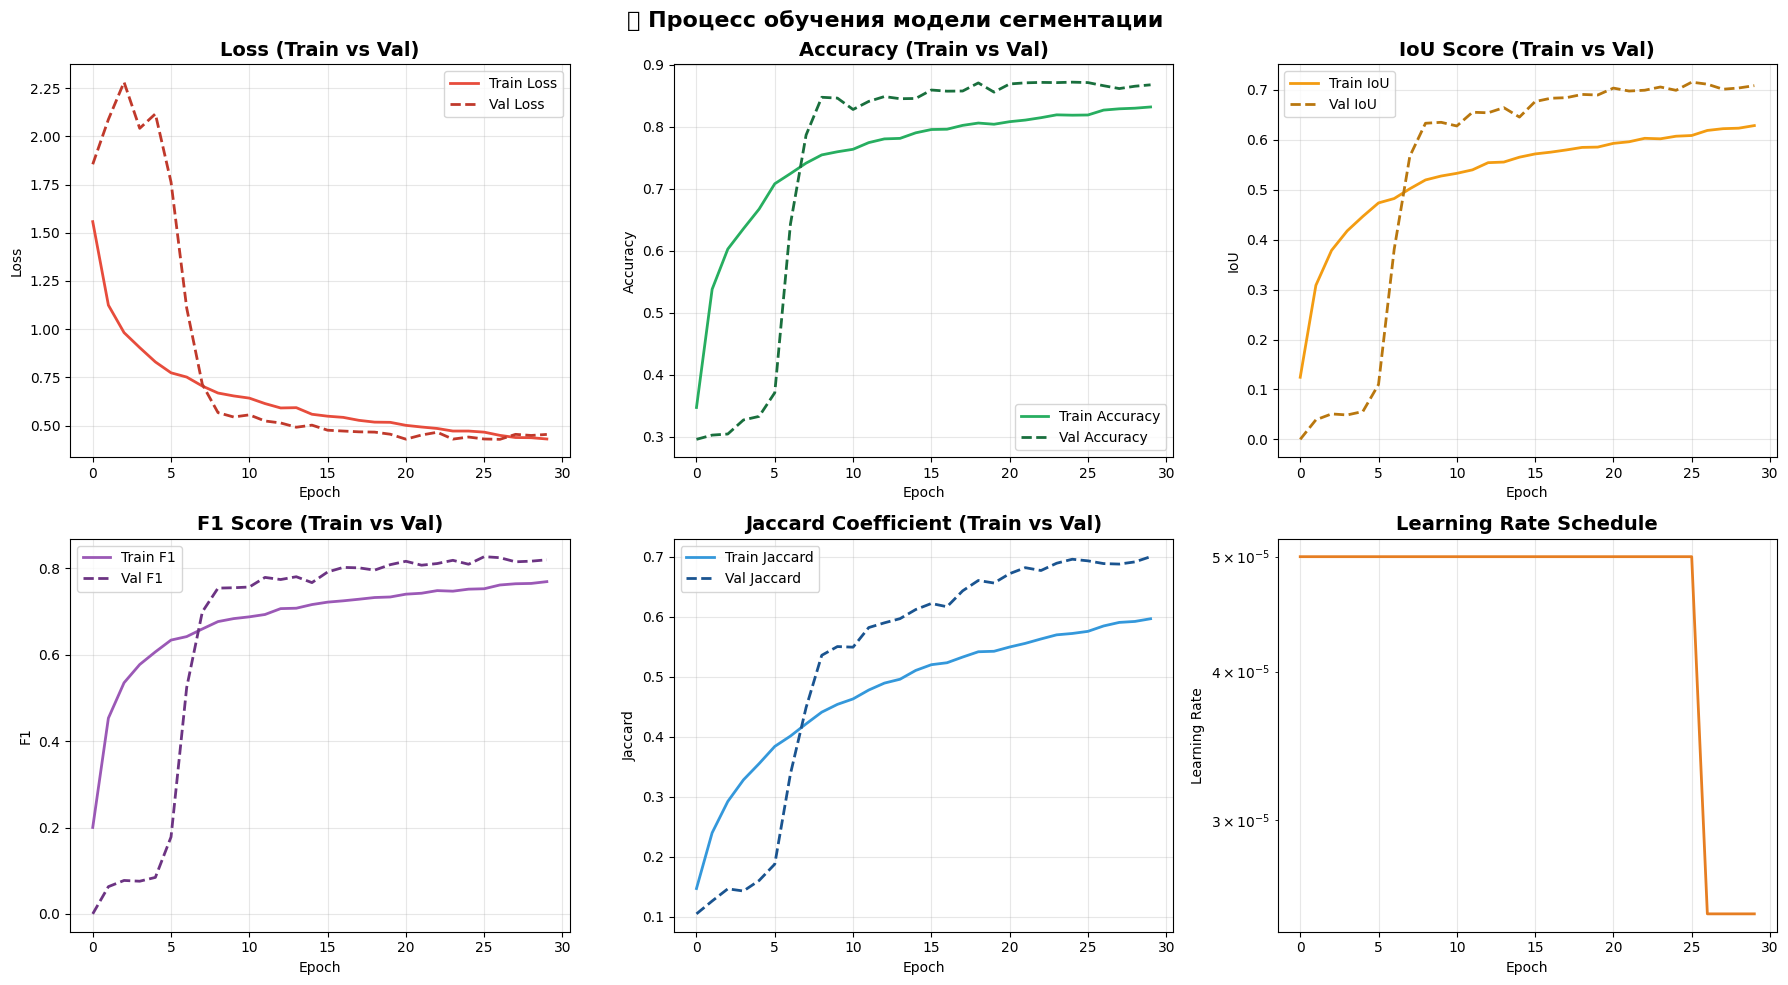

In [25]:
# 3.4. Визуализация процесса обучения

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Процесс обучения модели сегментации', fontsize=16, fontweight='bold')

# 1. Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='#e74c3c')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#c0392b', linestyle='--')
axes[0, 0].set_title('Loss (Train vs Val)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Accuracy (Train vs Val)
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#27ae60')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#196f3d', linestyle='--')
axes[0, 1].set_title('Accuracy (Train vs Val)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. IoU Score (Train vs Val)
axes[0, 2].plot(history.history['iou_score'], label='Train IoU', linewidth=2, color='#f39c12')
axes[0, 2].plot(history.history['val_iou_score'], label='Val IoU', linewidth=2, color='#b9770e', linestyle='--')
axes[0, 2].set_title('IoU Score (Train vs Val)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('IoU')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. F1 Score (Train vs Val)
axes[1, 0].plot(history.history['f1_score'], label='Train F1', linewidth=2, color='#9b59b6')
axes[1, 0].plot(history.history['val_f1_score'], label='Val F1', linewidth=2, color='#6c3483', linestyle='--')
axes[1, 0].set_title('F1 Score (Train vs Val)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5. Jaccard Coefficient (Train vs Val)
axes[1, 1].plot(history.history['jacard_coef'], label='Train Jaccard', linewidth=2, color='#3498db')
axes[1, 1].plot(history.history['val_jacard_coef'], label='Val Jaccard', linewidth=2, color='#1a5490', linestyle='--')
axes[1, 1].set_title('Jaccard Coefficient (Train vs Val)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Jaccard')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Learning Rate (если есть)
if 'lr' in history.history or 'learning_rate' in history.history:
    lr_key = 'lr' if 'lr' in history.history else 'learning_rate'
    axes[1, 2].plot(history.history[lr_key], linewidth=2, color='#e67e22')
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Learning Rate')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(alpha=0.3)
else:
    # Сравнение всех метрик на одном графике
    axes[1, 2].plot(history.history['iou_score'], label='IoU', linewidth=2, alpha=0.7)
    axes[1, 2].plot(history.history['f1_score'], label='F1', linewidth=2, alpha=0.7)
    axes[1, 2].plot(history.history['jacard_coef'], label='Jaccard', linewidth=2, alpha=0.7)
    axes[1, 2].set_title('Сравнение метрик', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_plots.png', dpi=150, bbox_inches='tight')
print("💾 Графики сохранены в: /content/training_plots.png")
plt.show()

🔍 ВАЛИДАЦИЯ МОДЕЛИ НА СЛУЧАЙНЫХ ПРИМЕРАХ


Found 1920 images belonging to 1 classes.
Found 1920 images belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

💾 Результаты валидации сохранены в: /content/validation_results.png


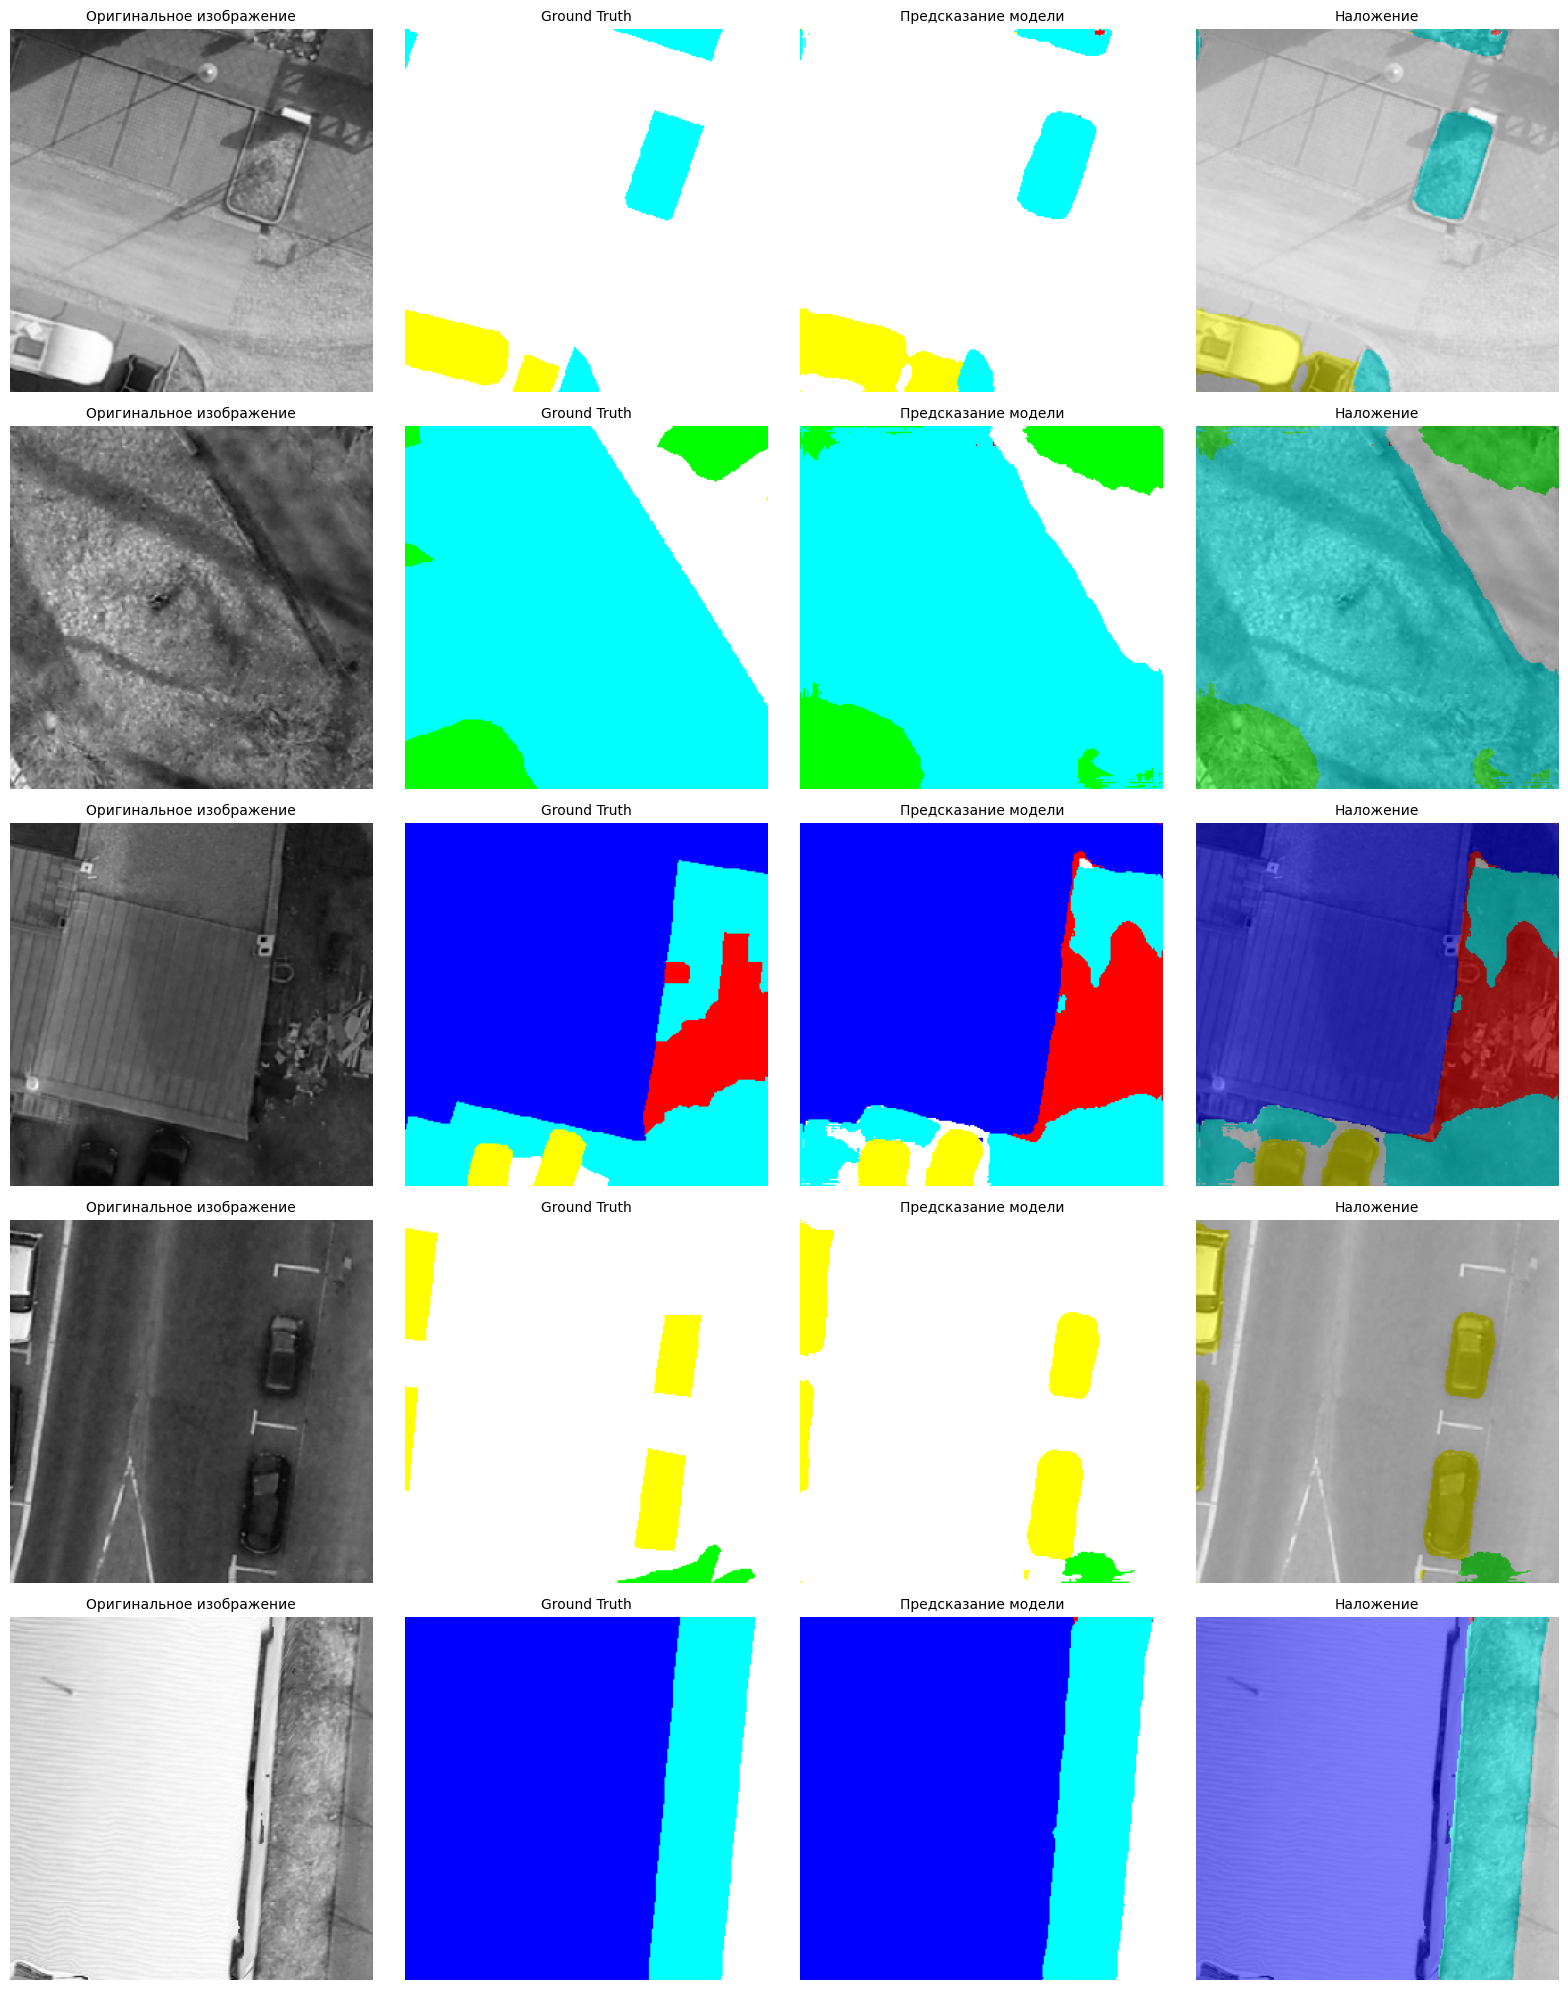


✅ Валидация завершена!


In [26]:
# 3.5. Валидация модели на случайных примерах

print("🔍 ВАЛИДАЦИЯ МОДЕЛИ НА СЛУЧАЙНЫХ ПРИМЕРАХ")
print("="*70)

# Загружаем лучшую модель
model = keras.models.load_model(
    '/content/best_segmentation_model.h5',
    custom_objects={
        'jacard_coef': jacard_coef,
        'loss': weighted_loss  # Добавляем weighted loss для загрузки модели
    }
)

# Создаем генератор заново
train_img_gen = trainGenerator(train_img_dir, train_mask_dir, num_class=6)

# Получаем batch данных
x_val, y_val = train_img_gen.__next__()

# Предсказания
y_pred = model.predict(x_val)

# Визуализация результатов
num_samples = min(5, len(x_val))  # Показываем 5 примеров

fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Оригинальное изображение
    image = x_val[i][:,:,0]
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title('Оригинальное изображение', fontsize=10)
    axes[i, 0].axis('off')
    
    # Ground truth маска
    mask_true = np.argmax(y_val[i], axis=2)
    axes[i, 1].imshow(mask_true, cmap=cmap, vmin=0, vmax=5)
    axes[i, 1].set_title('Ground Truth', fontsize=10)
    axes[i, 1].axis('off')
    
    # Предсказанная маска
    mask_pred = np.argmax(y_pred[i], axis=2)
    axes[i, 2].imshow(mask_pred, cmap=cmap, vmin=0, vmax=5)
    axes[i, 2].set_title('Предсказание модели', fontsize=10)
    axes[i, 2].axis('off')
    
    # Наложение предсказания на изображение
    axes[i, 3].imshow(image, cmap='gray')
    axes[i, 3].imshow(mask_pred, cmap=cmap, alpha=0.5, vmin=0, vmax=5)
    axes[i, 3].set_title('Наложение', fontsize=10)
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('/content/validation_results.png', dpi=150, bbox_inches='tight')
print("\n💾 Результаты валидации сохранены в: /content/validation_results.png")
plt.show()

print("\n✅ Валидация завершена!")

Сбор предсказаний для анализа...
Found 1920 images belonging to 1 classes.
Found 1920 images belonging to 1 classes.

📊 ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

       roads     0.9686    0.9165    0.9418   6214428
   buildings     0.9827    0.9725    0.9776   5455724
     low_veg     0.9562    0.8649    0.9082   5173709
       trees     0.8176    0.9577    0.8821   2692077
        cars     0.7738    0.9896    0.8685    364654
     clutter     0.7464    0.9708    0.8439   1070928

    accuracy                         0.9277  20971520
   macro avg     0.8742    0.9453    0.9037  20971520
weighted avg     0.9351    0.9277    0.9289  20971520


💾 Матрица ошибок сохранена в: /content/confusion_matrix.png


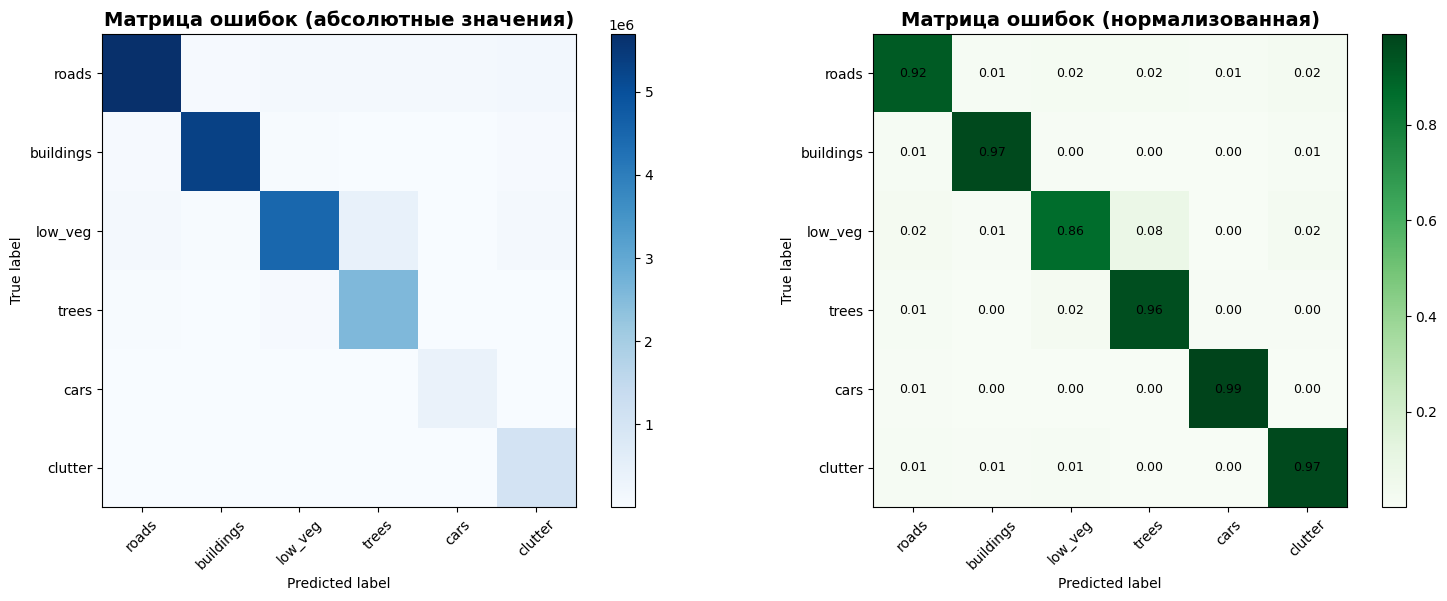


✅ Анализ по классам завершен!


In [27]:
# 3.6. Анализ качества предсказаний по каждому классу

from sklearn.metrics import classification_report, confusion_matrix

# Получаем предсказания на большем количестве данных
print("Сбор предсказаний для анализа...")
y_true_all = []
y_pred_all = []

# Генерируем новый генератор
train_img_gen = trainGenerator(train_img_dir, train_mask_dir, num_class=6)

for i in range(min(20, steps_per_epoch)):  # 20 батчей
    x_batch, y_batch = train_img_gen.__next__()
    y_pred_batch = model.predict(x_batch, verbose=0)
    
    y_true_all.extend(np.argmax(y_batch, axis=-1).flatten())
    y_pred_all.extend(np.argmax(y_pred_batch, axis=-1).flatten())

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Classification report
class_names = ['roads', 'buildings', 'low_veg', 'trees', 'cars', 'clutter']

print("\n" + "="*70)
print("📊 ОТЧЕТ ПО КЛАССАМ:")
print("="*70)
print(classification_report(y_true_all, y_pred_all, 
                          target_names=class_names, 
                          digits=4))

# Матрица ошибок
cm = confusion_matrix(y_true_all, y_pred_all)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Визуализация матрицы ошибок
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Абсолютные значения
im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.set_title('Матрица ошибок (абсолютные значения)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.set_xticks(np.arange(len(class_names)))
ax1.set_yticks(np.arange(len(class_names)))
ax1.set_xticklabels(class_names, rotation=45)
ax1.set_yticklabels(class_names)
plt.colorbar(im1, ax=ax1)

# Нормализованные значения
im2 = ax2.imshow(cm_normalized, interpolation='nearest', cmap='Greens')
ax2.set_title('Матрица ошибок (нормализованная)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.set_xticks(np.arange(len(class_names)))
ax2.set_yticks(np.arange(len(class_names)))
ax2.set_xticklabels(class_names, rotation=45)
ax2.set_yticklabels(class_names)
plt.colorbar(im2, ax=ax2)

# Добавляем значения в ячейки
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax2.text(j, i, f'{cm_normalized[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=150, bbox_inches='tight')
print("\n💾 Матрица ошибок сохранена в: /content/confusion_matrix.png")
plt.show()

print("\n✅ Анализ по классам завершен!")

In [ ]:
# ============================================================
# СОЗДАНИЕ ВРЕМЕННЫХ ССЫЛОК ДЛЯ СКАЧИВАНИЯ ФАЙЛОВ
# ============================================================

# Установка ngrok
!pip install pyngrok -q

import os
import shutil
from pyngrok import ngrok, conf
import threading
from http.server import SimpleHTTPRequestHandler, HTTPServer

# 1. Собираем все файлы в одну папку
download_folder = '/content/download_files'
os.makedirs(download_folder, exist_ok=True)

print("📦 Подготовка файлов для скачивания...\n")

# Список файлов для скачивания
files_to_prepare = {
    '/content/best_segmentation_model.h5': 'best_segmentation_model.h5',
    '/content/drive/MyDrive/best_segmentation_model.h5': 'best_segmentation_model.h5',
    '/content/training_plots.png': 'training_plots.png',
    '/content/drive/MyDrive/training_plots.png': 'training_plots.png',
    '/content/validation_results.png': 'validation_results.png',
    '/content/drive/MyDrive/validation_results.png': 'validation_results.png',
    '/content/confusion_matrix.png': 'confusion_matrix.png',
    '/content/drive/MyDrive/confusion_matrix.png': 'confusion_matrix.png',
    '/content/training_history.csv': 'training_history.csv',
    '/content/drive/MyDrive/training_history.csv': 'training_history.csv',
}

# Копируем файлы
copied_files = []
for source, filename in files_to_prepare.items():
    if os.path.exists(source):
        dest = os.path.join(download_folder, filename)
        if not os.path.exists(dest):  # Избегаем дублирования
            shutil.copy(source, dest)
            size_mb = os.path.getsize(dest) / (1024*1024)
            print(f"✅ {filename} ({size_mb:.2f} MB)")
            copied_files.append(filename)

if not copied_files:
    print("⚠️  Файлы не найдены! Проверьте пути.")
else:
    print(f"\n📊 Всего файлов: {len(copied_files)}")

# 2. Запускаем HTTP сервер в фоне
os.chdir(download_folder)

class MyHandler(SimpleHTTPRequestHandler):
    def log_message(self, format, *args):
        pass  # Отключаем логи

def start_server():
    server = HTTPServer(('0.0.0.0', 8000), MyHandler)
    server.serve_forever()

# Запускаем сервер в отдельном потоке
server_thread = threading.Thread(target=start_server, daemon=True)
server_thread.start()

print("\n🌐 Запуск HTTP сервера...")

# 3. Создаем публичную ссылку через ngrok
try:
    # Авторизация ngrok
    conf.get_default().auth_token = "35sZ5fHrDUgtpmp76bpUqxqa5zM_7buLsiKE68Q5azxGBHq9"
    public_url = ngrok.connect(8000)
    
    print("\n" + "="*70)
    print("✅ ВРЕМЕННЫЕ ССЫЛКИ ДЛЯ СКАЧИВАНИЯ:")
    print("="*70)
    print(f"\n🔗 Главная страница (список файлов):")
    print(f"   {public_url}")
    print(f"\n📥 Прямые ссылки на файлы:\n")
    
    for filename in copied_files:
        file_url = f"{public_url}/{filename}"
        print(f"   • {filename}")
        print(f"     {file_url}\n")
    
    print("="*70)
    print("⚠️  ВАЖНО:")
    print("   • Ссылки действуют только пока работает Colab")
    print("   • Скачайте файлы, пока ячейка выполняется")
    print("   • Для остановки: Runtime → Interrupt execution")
    print("="*70)
    
    # Держим сервер запущенным
    print("\n⏳ Сервер работает... Нажмите 'Остановить' когда скачаете файлы.")
    
    # Бесконечный цикл (держит ячейку запущенной)
    import time
    while True:
        time.sleep(1)
        
except KeyboardInterrupt:
    print("\n🛑 Сервер остановлен")
    ngrok.kill()
except Exception as e:
    print(f"\n❌ Ошибка: {e}")
    print("\n💡 Альтернатива: используйте files.download() для прямого скачивания")

📦 Подготовка файлов для скачивания...

✅ best_segmentation_model.h5 (280.41 MB)
✅ training_plots.png (0.25 MB)
✅ validation_results.png (1.92 MB)
✅ confusion_matrix.png (0.09 MB)
✅ training_history.csv (0.01 MB)

📊 Всего файлов: 5

🌐 Запуск HTTP сервера...
                                                                                                    
✅ ВРЕМЕННЫЕ ССЫЛКИ ДЛЯ СКАЧИВАНИЯ:

🔗 Главная страница (список файлов):
   NgrokTunnel: "https://idiomorphically-unserrated-catheryn.ngrok-free.dev" -> "http://localhost:8000"

📥 Прямые ссылки на файлы:

   • best_segmentation_model.h5
     NgrokTunnel: "https://idiomorphically-unserrated-catheryn.ngrok-free.dev" -> "http://localhost:8000"/best_segmentation_model.h5

   • training_plots.png
     NgrokTunnel: "https://idiomorphically-unserrated-catheryn.ngrok-free.dev" -> "http://localhost:8000"/training_plots.png

   • validation_results.png
     NgrokTunnel: "https://idiomorphically-unserrated-catheryn.ngrok-free.dev" -> "http://loca

: 